C:\Users\USER\AppData\Local\Temp\ipykernel_1084\2805103074.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_school_data['진학 학생수'] = high_school_data[
C:\Users\USER\AppData\Local\Temp\ipykernel_1084\2805103074.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_school_data['진학률'] = high_school_data['국내대학진학학생수'] / high_school_data['진학 학생수']
C:\Users\USER\AppData\Local\Temp\ipykernel_1084\2805103074.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

CSV file saved to final_graded_school_locations.csv


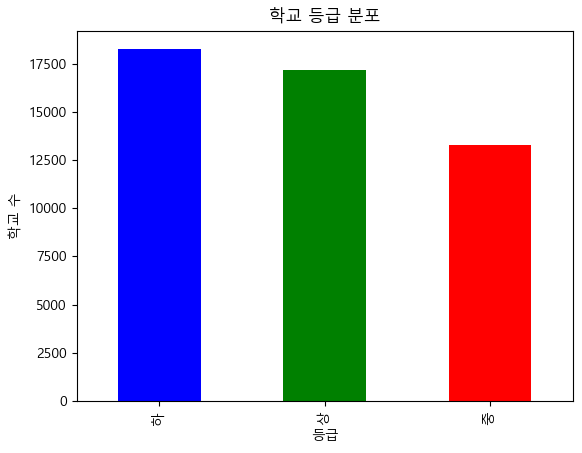

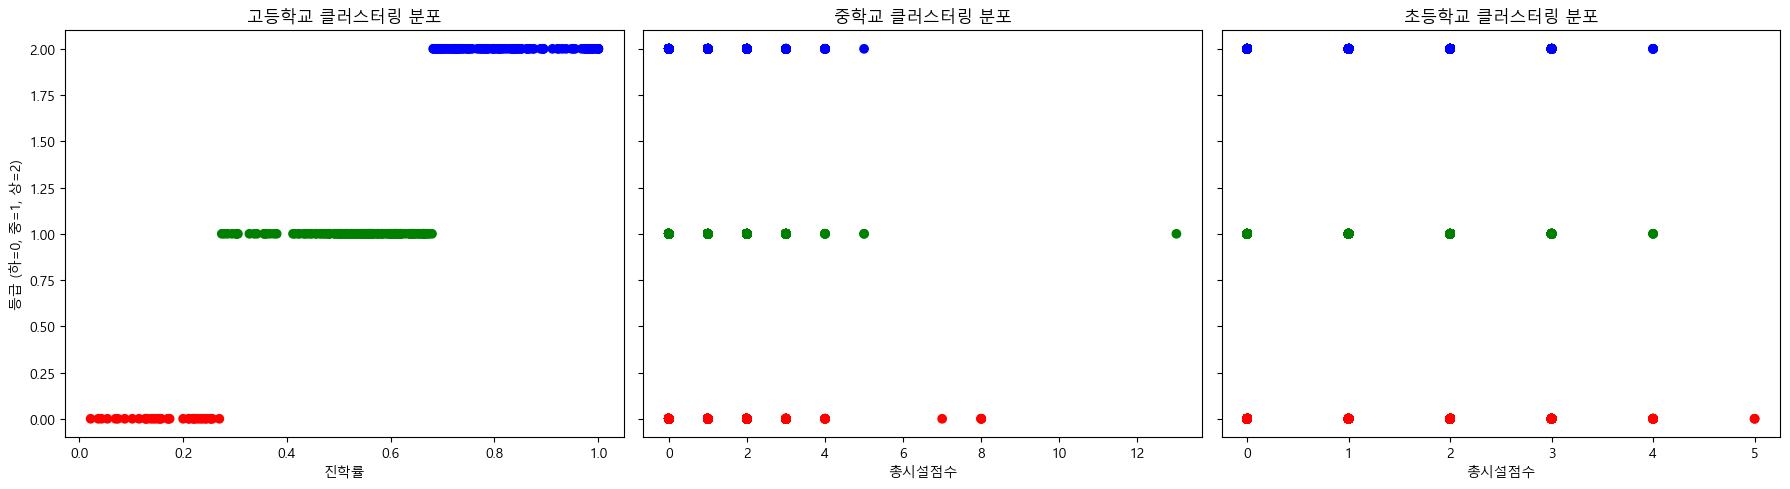

In [6]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Set font to avoid issues with displaying Korean characters
plt.rcParams['font.family'] = 'Malgun Gothic'  # For Windows, use 'AppleGothic' for macOS
plt.rcParams['axes.unicode_minus'] = False

# Load the data from uploaded files
jinak_su_data_path = '유치원초중고 진학수및 취업수 통계 자료 2019_2024 (1).csv'
location_data_path = '초중고위치데이터_위도_경도.csv'
facility_data_path = '유치원초중고 시설정보 2019_2024.csv'
updated_facility_data_path = '유치원초중고 시설정보 2019_2024.csv'

jinak_su_data = pd.read_csv(jinak_su_data_path)
location_data = pd.read_csv(location_data_path)
facility_data = pd.read_csv(facility_data_path)
updated_facility_data = pd.read_csv(updated_facility_data_path)

# Step 1: Filter data for high schools and calculate ratio of students progressing to colleges
high_school_data = jinak_su_data[jinak_su_data['학제유형명'].str.contains('고등학교')]
high_school_data['진학 학생수'] = high_school_data[
    ['국내대학진학학생수', '국내전문대학진학학생수', '국내각종학교진학학생수', '국내교육대학진학학생수']
].sum(axis=1)
high_school_data['진학률'] = high_school_data['국내대학진학학생수'] / high_school_data['진학 학생수']

# Apply K-means clustering for high schools using the new ratio
kmeans_high = KMeans(n_clusters=3, random_state=42)
high_school_data['등급'] = kmeans_high.fit_predict(high_school_data[['진학률']].fillna(0))
high_school_data['등급'] = high_school_data['등급'].map({0: '하', 1: '중', 2: '상'})

# Step 2: Use facility information to grade middle schools with additional data
middle_school_data = facility_data[facility_data['학교급명'].str.contains('중학교')]
middle_school_data['총시설점수'] = middle_school_data[['교사_학교사옥면적', '체육공간수', '교사_도서관수']].sum(axis=1)  # Adding facility scores for clustering
middle_school_data['교실당학생수'] = middle_school_data['일반교실수'] / (middle_school_data['교사_학교사옥면적'] + 1e-5)  # New metric: students per classroom area
middle_school_columns = ['교사_학교사옥면적', '체육공간수', '교사_도서관수', '총시설점수', '교실당학생수']
kmeans_middle = KMeans(n_clusters=3, random_state=42)
middle_school_data['등급'] = kmeans_middle.fit_predict(middle_school_data[middle_school_columns].fillna(0))
middle_school_data['등급'] = middle_school_data['등급'].map({0: '하', 1: '중', 2: '상'})

# Step 3: Use facility information to grade elementary schools with additional data
elementary_data = facility_data[facility_data['학교급명'].str.contains('초등학교')]
elementary_data['총시설점수'] = elementary_data[['교사_학교사옥면적', '체육공간수', '교사_도서관수']].sum(axis=1)  # Adding facility scores for clustering
elementary_data['교실당학생수'] = elementary_data['일반교실수'] / (elementary_data['교사_학교사옥면적'] + 1e-5)  # New metric: students per classroom area
elementary_columns = ['교사_학교사옥면적', '체육공간수', '교사_도서관수', '총시설점수', '교실당학생수']
kmeans_elementary = KMeans(n_clusters=3, random_state=42)
elementary_data['등급'] = kmeans_elementary.fit_predict(elementary_data[elementary_columns].fillna(0))
elementary_data['등급'] = elementary_data['등급'].map({0: '하', 1: '중', 2: '상'})

# Step 4: Merge location data with graded schools (high schools, middle schools, and elementary schools)
graded_schools = pd.concat([
    high_school_data[['학교명', '등급']],
    middle_school_data[['학교명', '등급']],
    elementary_data[['학교명', '등급']]
])

# Merge with location data to get latitude and longitude
final_data = pd.merge(graded_schools, location_data, how='left', on='학교명')
final_data = final_data[['학교명', 'lat', 'lon', '등급']]

# Save the final result to a CSV file
output_path = 'final_graded_school_locations.csv'
final_data.to_csv(output_path, index=False)

print(f"CSV file saved to {output_path}")

# Plot distribution of grades
grade_counts = final_data['등급'].value_counts()
grade_counts.plot(kind='bar', color=['blue', 'green', 'red'])
plt.xlabel('등급')
plt.ylabel('학교 수')
plt.title('학교 등급 분포')
plt.show()

# Plot clustering distributions for high schools, middle schools, and elementary schools
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# High school clustering distribution
axes[0].scatter(high_school_data['진학률'], high_school_data['등급'].map({'하': 0, '중': 1, '상': 2}), c=high_school_data['등급'].map({'하': 'red', '중': 'green', '상': 'blue'}))
axes[0].set_xlabel('진학률')
axes[0].set_ylabel('등급 (하=0, 중=1, 상=2)')
axes[0].set_title('고등학교 클러스터링 분포')

# Middle school clustering distribution
axes[1].scatter(middle_school_data['총시설점수'], middle_school_data['등급'].map({'하': 0, '중': 1, '상': 2}), c=middle_school_data['등급'].map({'하': 'red', '중': 'green', '상': 'blue'}))
axes[1].set_xlabel('총시설점수')
axes[1].set_title('중학교 클러스터링 분포')

# Elementary school clustering distribution
axes[2].scatter(elementary_data['총시설점수'], elementary_data['등급'].map({'하': 0, '중': 1, '상': 2}), c=elementary_data['등급'].map({'하': 'red', '중': 'green', '상': 'blue'}))
axes[2].set_xlabel('총시설점수')
axes[2].set_title('초등학교 클러스터링 분포')

plt.tight_layout()
plt.show()
